# Boosting a decision stump

The goal of this notebook is to implement your own boosting module.

* First to do some feature engineering.
* Modify the decision trees to incorporate weights.
* Implement Adaboost ensembling.
* Use your implementation of Adaboost to train a boosted decision stump ensemble.
* Evaluate the effect of boosting (adding more decision stumps) on performance of the model.
* Explore the robustness of Adaboost to overfitting.

In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

# Getting the data ready

In [3]:
loans = pd.read_csv('data_files/lending-club-data.csv')
loans.columns

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (19,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

In [4]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis=1)
target = 'safe_loans'
loans = loans[features + [target]]

In [5]:
print (loans.shape)

(122607, 5)


## Subample data to balance classes

As we explored above, our data is disproportionally full of safe loans.  Let's create two datasets: one with just the safe loans (`safe_loans_raw`) and one with just the risky loans (`risky_loans_raw`).

Purpose: Deal with imbalanced data by subsampling the overly represented class to get a more balanced dataset

In [8]:
#safe_loans_raw = loans[loans[target] == +1]
#risky_loans_raw = loans[loans[target] == -1]
#print("Number of safe loans  : %s" % len(safe_loans_raw))
#print("Number of risky loans : %s" % len(risky_loans_raw))

# Since there are fewer risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
#percentage = len(risky_loans_raw)/float(len(safe_loans_raw))

#risky_loans = risky_loans_raw
#safe_loans = safe_loans_raw.sample(percentage, seed=1)

# Append the risky_loans with the downsampled version of safe_loans
#loans_data = risky_loans.append(safe_loans)

### Transform categorical feature to binary features

In [9]:
loans = loans.fillna('n/a')

In [10]:
categorical_variables = []
for feat_name, feat_type in zip(loans.columns, loans.dtypes):
    if feat_type == object:
        categorical_variables.append(feat_name)
        
for feature in categorical_variables:
    
    loans_one_hot_encoded = pd.get_dummies(loans[feature],prefix=feature)
    loans_one_hot_encoded.fillna(0)
    #print loans_one_hot_encoded
    
    loans = loans.drop(feature, axis=1)
    for col in loans_one_hot_encoded.columns:
        loans[col] = loans_one_hot_encoded[col]
        
loans.head(2)

,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,...,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_n/a
0,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [19]:
loans.columns

Index(['safe_loans', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'term_ 36 months', 'term_ 60 months',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'emp_length_1 year', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years',
       'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years',
       'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year',
       'emp_length_n/a'],
      dtype='object')

In [62]:
features = list(loans.columns.drop('safe_loans'))
features

['grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'term_ 36 months',
 'term_ 60 months',
 'home_ownership_MORTGAGE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'emp_length_1 year',
 'emp_length_10+ years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_< 1 year',
 'emp_length_n/a']

### Train test split

In [11]:
with open('data_files/module-8-assignment-2-train-idx.json') as train_data_file:    
    train_idx  = json.load(train_data_file)
with open('data_files/module-8-assignment-2-test-idx.json') as test_data_file:    
    test_idx = json.load(test_data_file)
    
train_data = loans.iloc[train_idx]
test_data = loans.iloc[test_idx]

In [12]:
print(train_data.shape, test_data.shape)

(37224, 26) (9284, 26)


# Weighted decision trees

Let's modify our decision tree code from Module 5 to support weighting of individual data points.

### Function: intermediate_node_weighted_mistakes

In [10]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    
    total_weight_positive = sum(data_weights[labels_in_node == 1])  # weightes of mistakes for predicting -1  
    total_weight_negative = sum(data_weights[labels_in_node == -1]) # weightes of mistakes for predicting +1
   
    if total_weight_positive >= total_weight_negative:
        return (total_weight_negative,+1)    # return the weighted mistake, predicted class
    else:
        return (total_weight_positive,-1)  

In [31]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    ### YOUR CODE HERE
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    ### YOUR CODE HERE
    if weighted_mistakes_all_negative >= weighted_mistakes_all_positive:
        return (weighted_mistakes_all_positive, +1)    # return the weighted mistake, predicted class
    else:
        return (weighted_mistakes_all_negative, -1)

#### checkpoint

In [32]:
example_labels = np.array([-1, -1, 1, 1, 1]) # labels in the node
example_data_weights = np.array([5.5, 2, 0.5, 1, 1])

if intermediate_node_weighted_mistakes(example_labels, example_data_weights) == (2.5, -1):
    print ('Test passed!')
else:
    print ('Test failed... try again!')

Test passed!


### Function:best_splitting_feature

We continue modifying our decision tree code from the earlier assignment to incorporate weighting of individual data points. The next step is to pick the best feature to split on.

The **best_splitting_feature** function is similar to the one from the earlier assignment with two minor modifications:
  1. The function **best_splitting_feature** should now accept an extra parameter `data_weights` to take account of weights of data points.
  2. Instead of computing the number of mistakes in the left and right side of the split, we compute the weight of mistakes for both sides, add up the two weights, and divide it by the total weight of the data.
  
Complete the following function. Comments starting with `DIFFERENT HERE` mark the sections where the weighted version differs from the original implementation.

In [48]:
def best_splitting_feature(data,features,target,data_weights):
    
    best_feature = None
    best_error = float('+inf')
    num_points = float(len(data))
    #data['data_weights'] = data_weights
    
    for feature in features:
        left_split = data[data[feature] ==0]   # data points in the left split
        right_split = data[data[feature] ==1]  # data points in the right split
        
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
        #left_data_weights = left_split['data_weights']   # weights of data in the left split
        #right_data_weights = right_split['data_weights'] # weights of data in the right split
        
        # weights of mistakes in left split
        left_mistakes_weights,left_class = intermediate_node_weighted_mistakes(left_split[target], left_data_weights) 
        # weights of mistakes in right split
        right_mistakes_weights,right_class = intermediate_node_weighted_mistakes(right_split[target], right_data_weights)
        
        error = (left_mistakes_weights + right_mistakes_weights)/sum(data_weights) # weighted of mistakes from two sides
        
        if error < best_error:
            best_feature = feature
            best_error = error
    
    return best_feature

#### checkpoint

In [49]:
example_data_weights = np.array(len(train_data)* [1.5])

if best_splitting_feature(train_data, features, target, example_data_weights) == 'term_ 36 months':
    print ('Test passed!')
else:
    print ('Test failed... try again!')

Test passed!


### Building the tree

With the above functions implemented correctly, we are now ready to build our decision tree. Recall from the previous assignments that each node in the decision tree is represented as a dictionary which contains the following keys:

    { 
       'is_leaf'            : True/False.
       'prediction'         : Prediction at the leaf node.
       'left'               : (dictionary corresponding to the left tree).
       'right'              : (dictionary corresponding to the right tree).
       'features_remaining' : List of features that are posible splits.
    }
    
Let us start with a function that creates a leaf node given a set of target values:

In [50]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class
    
    return leaf

We provide a function that learns a weighted decision tree recursively and implements 3 stopping conditions:
1. All data points in a node are from the same class.
2. No more features to split on.
3. Stop growing the tree when the tree depth reaches **max_depth**. 

In [63]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    
    #data['data_weights'] = data_weights
    
    print ("--------------------------------------------------------------------")
    print ('Subtree, depth = {0} ({1} data points).'.format(current_depth, len(target_values)))
    
    # Stopping condition 1. sum of (weighted) Error in node is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print ("Stopping condition 1 reached.")                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print ("Stopping condition 2 reached.")                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print ("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]

    #left_data_weights = left_split['data_weights']
    #right_data_weights = right_split['data_weights']
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    #left_data_weights = np.array(left_split['data_weights'])
    #right_data_weights = np.array(right_split['data_weights'])
    
    print ('Split on feature {0}. ({1}, {2})'.format(splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

In [60]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [64]:
example_data_weights = np.array([1.0 for i in range(len(train_data))])
small_data_decision_tree = weighted_decision_tree_create(train_data, features, target,
                                        example_data_weights, max_depth=2)
if count_nodes(small_data_decision_tree) == 7:
    print ('Test passed!')
else:
    print ('Test failed... try again!')
    print ('Number of nodes found:', count_nodes(small_data_decision_tree))
    print ('Number of nodes that should be there: 7')

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Split on feature grade_A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 3 (9122 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (101 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Split on feature grade_D. (23300, 4701)
--------------------------------------------------------------------
Subtree, depth = 3 (23300 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (4701 data po

In [65]:
small_data_decision_tree

{'is_leaf': False,
 'prediction': None,
 'splitting_feature': 'term_ 36 months',
 'left': {'is_leaf': False,
  'prediction': None,
  'splitting_feature': 'grade_A',
  'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1},
  'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}},
 'right': {'is_leaf': False,
  'prediction': None,
  'splitting_feature': 'grade_D',
  'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1},
  'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}}}

### Making predictions with a weighted decision tree
We give you a function that classifies one data point. It can also return the probability if you want to play around with that as well.

In [66]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

### Evaluating the tree

Now, we will write a function to evaluate a decision tree by computing the classification error of the tree on the given dataset.

Again, recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

The function called **evaluate_classification_error** takes in as input:
1. `tree` (as described above)
2. `data` (an SFrame)

The function does not change because of adding data point weights.

In [69]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x), axis = 1)
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [70]:
evaluate_classification_error(small_data_decision_tree, test_data)

0.3981042654028436

### Example: Training a weighted decision tree

To build intuition on how weighted data points affect the tree being built, consider the following:

Suppose we only care about making good predictions for the **first 10 and last 10 items** in `train_data`, we assign weights:
* 1 to the last 10 items 
* 1 to the first 10 items 
* and 0 to the rest. 

Let us fit a weighted decision tree with `max_depth = 2`.

In [71]:
# Assign weights
example_data_weights = np.array([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)

# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                                                                   example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade_F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade_D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

In [72]:
# Now, we will compute the classification error on the subset_20, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points).
subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.05

In [73]:
#Now, let us compare the classification error of the model small_data_decision_tree_subset_20 on the entire train_data:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.48124865678057166

The model `small_data_decision_tree_subset_20` performs **a lot** better on `subset_20` than on `train_data`.

So, what does this mean?
* The points with higher weights are the ones that are more important during the training process of the weighted decision tree.
* The points with zero weights are basically ignored during training.

# Implementing your own Adaboost (on decision stumps)

Now that we have a weighted decision tree working, it takes only a bit of work to implement Adaboost. For the sake of simplicity, let us stick with **decision tree stumps** by training trees with **`max_depth=1`**.

Recall from the lecture the procedure for Adaboost:

1\. Start with unweighted data with $\alpha_j = 1$

2\. For t = 1,...T:
  * Learn $f_t(x)$ with data weights $\alpha_j$
  * Compute coefficient $\hat{w}_t$(amount of say of a stump):
     $$\hat{w}_t = \frac{1}{2}\ln{\left(\frac{1- \mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}\right)}$$
  * Re-compute weights $\alpha_j$:
     $$\alpha_j \gets \begin{cases}
     \alpha_j \exp{(-\hat{w}_t)} & \text{ if }f_t(x_j) = y_j\\
     \alpha_j \exp{(\hat{w}_t)} & \text{ if }f_t(x_j) \neq y_j
     \end{cases}$$
  * Normalize weights $\alpha_j$:
      $$\alpha_j \gets \frac{\alpha_j}{\sum_{i=1}^{N}{\alpha_i}} $$

In [79]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.array([1.]*len(data))  # initial weights
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print('=====================================================')
        print('Adaboost Iteration %d' % t)
        print('=====================================================')
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = data.apply(lambda x: classify(tree_stump, x), axis = 1)
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = (predictions == target_values)
        is_wrong   = (predictions != target_values)
        
        # Compute weighted error
        weighted_error = sum(is_wrong * alpha) / sum(alpha)
        
        # Compute model coefficient using weighted error
        
        # step1: compute amount of say of a stump
        weight = 1/2 * np.log((1 - weighted_error) / weighted_error)
        weights.append(weight)
        
        # step2: re-compute weight
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        
        # step3: normalize data points weights
        alpha = alpha*adjustment  
        alpha = alpha / sum(alpha) 
    
    return weights, tree_stumps

In [80]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.


In [81]:
def print_stump(tree):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print ("(leaf, label: %s)" % tree['prediction'])
        return None
    split_feature, split_value = split_name.split('_')
    print ('                       root')
    print ('         |---------------|----------------|')
    print ('         |                                |')
    print ('         |                                |')
    print ('         |                                |')
    print ('  [{0} == 0]{1}[{0} == 1]    '.format(split_name, ' '*(27-len(split_name))))
    print ('         |                                |')
    print ('         |                                |')
    print ('         |                                |')
    print ('    (%s)                 (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree')))

Here is what the first stump looks like:

In [82]:
print_stump(tree_stumps[0])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term_ 36 months == 0]            [term_ 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


Here is what the next stump looks like:

In [83]:
print_stump(tree_stumps[1])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade_A == 0]                    [grade_A == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


If your Adaboost is correctly implemented, the following things should be true:

* `tree_stumps[0]` should split on **term. 36 months** with the prediction -1 on the left and +1 on the right.
* `tree_stumps[1]` should split on **grade.A** with the prediction -1 on the left and +1 on the right.
* Weights should be approximately `[0.158, 0.177]` 

**Reminders**
- Stump weights ($\mathbf{\hat{w}}$) and data point weights ($\mathbf{\alpha}$) are two different concepts.
- Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.
- Data point weights ($\mathbf{\alpha}$) tell you how important each data point is while training a decision stump.

## Training a boosted ensemble of 10 stumps
Let us train an ensemble of 10 decision tree stumps with Adaboost. We run the **adaboost_with_tree_stumps** function with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 10`

In [84]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, 
                                target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

## Making predictions

Recall from the lecture that in order to make predictions, we use the following formula:
$$
\hat{y} = sign\left(\sum_{t=1}^T \hat{w}_t f_t(x)\right)
$$

We need to do the following things:
- Compute the predictions $f_t(x)$ using the $t$-th decision tree
- Compute $\hat{w}_t f_t(x)$ by multiplying the `stump_weights` with the predictions $f_t(x)$ from the decision trees
- Sum the weighted predictions over each stump in the ensemble.

Complete the following skeleton for making predictions:

In [85]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.array([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x), axis = 1)
        
        # Accumulate predictions on scores array
        # YOUR CODE HERE
        # Update score function with weights[i] * predictions
        scores += stump_weights[i] * predictions
        
    return scores.apply(lambda score : +1 if score > 0 else -1)

In [86]:
predictions = predict_adaboost(stump_weights, tree_stumps, test_data)
accuracy = sum(test_data[target] == predictions)/len(predictions)
print ('Accuracy of 10 stump ensemble is = ',accuracy )

Accuracy of 10 stump ensemble is =  0.6203145196036192


In [87]:
# print the weights of ten stumps
stump_weights

[0.15802933659263743,
 0.1768236329364191,
 0.09311888971129693,
 0.07288885525840554,
 0.06706306914118143,
 0.06456916961644447,
 0.05456055779178564,
 0.04351093673362621,
 0.02898871150041245,
 0.02596250969152032]

# Performance plots

In this section, we will try to reproduce some of the performance plots dicussed in the lecture.

### How does accuracy change with adding stumps to the ensemble?

We will now train an ensemble with:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 30`

Once we are done with this, we will then do the following:
* Compute the classification error at the end of each iteration.
* Plot a curve of classification error vs iteration.

First, lets train the model.

In [88]:
# this may take a while... 
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, 
                                 features, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

Split on feature emp_length_n/a. (35781, 1443)
--------------------------------------------------------------------
Subtree, depth = 2 (35781 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (1443 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 15
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_C. (27812, 9412)
--------------------------------------------------------------------
Subtree, depth = 2 (27812 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (9412 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 16
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
-------------

Adaboost Iteration 29
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_C. (27812, 9412)
--------------------------------------------------------------------
Subtree, depth = 2 (27812 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (9412 data points).
Reached maximum depth. Stopping for now.


### Computing training error at the end of each iteration

Now, we will compute the classification error on the **train_data** and see how it is reduced as trees are added.

In [89]:
error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = 1.0 - sum(train_data[target] == predictions)/len(predictions)
    error_all.append(error)
    print("Iteration %s, training error = %s" % (n, error_all[n-1]))

Iteration 1, training error = 0.4216365785514722
Iteration 2, training error = 0.43343004513217276
Iteration 3, training error = 0.4000376101439931
Iteration 4, training error = 0.4000376101439931
Iteration 5, training error = 0.3847249086610789
Iteration 6, training error = 0.3846174511068128
Iteration 7, training error = 0.3827638082957232
Iteration 8, training error = 0.3846174511068128
Iteration 9, training error = 0.3827638082957232
Iteration 10, training error = 0.3844831291639802
Iteration 11, training error = 0.3827369439071566
Iteration 12, training error = 0.38144745325596385
Iteration 13, training error = 0.3815280464216635
Iteration 14, training error = 0.38056092843326883
Iteration 15, training error = 0.3805071996561358
Iteration 16, training error = 0.378223726627982
Iteration 17, training error = 0.3782774554051149
Iteration 18, training error = 0.3784117773479475
Iteration 19, training error = 0.3780625402965828
Iteration 20, training error = 0.3787610143993123
Iterati

### Visualizing training error vs number of iterations

We have provided you with a simple code snippet that plots classification error with the number of iterations. 

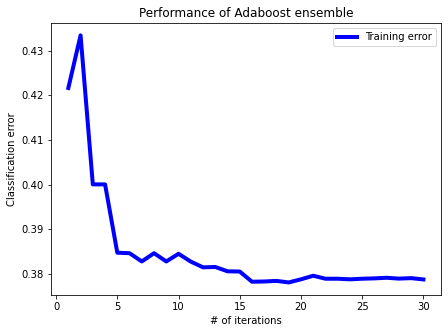

In [91]:
fig,ax = plt.subplots(figsize=(7,5))

ax.plot(range(1,31), error_all, linewidth=4.0, 
        linestyle = '-', label='Training error', color = 'blue')

ax.set_xlabel('# of iterations')
ax.set_ylabel('Classification error')
ax.set_title('Performance of Adaboost ensemble')
ax.legend()

plt.show()

### Evaluation on the test data

Performing well on the training data is cheating, so lets make sure it works on the `test_data` as well. Here, we will compute the classification error on the `test_data` at the end of each iteration.

In [93]:
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = 1.0 - sum(test_data[target] == predictions)/len(predictions)
    test_error_all.append(error)
    print ("Iteration %s, test error = %s" % (n, test_error_all[n-1]))

Iteration 1, test error = 0.4233089185695821
Iteration 2, test error = 0.4284791038345541
Iteration 3, test error = 0.3981042654028436
Iteration 4, test error = 0.3981042654028436
Iteration 5, test error = 0.37990090478242133
Iteration 6, test error = 0.38000861697544164
Iteration 7, test error = 0.37925463162429984
Iteration 8, test error = 0.38000861697544164
Iteration 9, test error = 0.37925463162429984
Iteration 10, test error = 0.37968548039638084
Iteration 11, test error = 0.37925463162429984
Iteration 12, test error = 0.37796208530805686
Iteration 13, test error = 0.37925463162429984
Iteration 14, test error = 0.37785437311503667
Iteration 15, test error = 0.37850064627315816
Iteration 16, test error = 0.37785437311503667
Iteration 17, test error = 0.37796208530805686
Iteration 18, test error = 0.37785437311503667
Iteration 19, test error = 0.37817750969409736
Iteration 20, test error = 0.3768849633778544
Iteration 21, test error = 0.37753123653597587
Iteration 22, test error = 

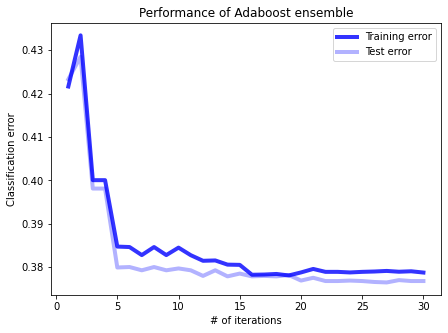

In [95]:
fig,ax = plt.subplots(figsize=(7,5))

ax.plot(range(1,31), error_all, linewidth=4.0, linestyle = '-', 
        label='Training error', color = 'blue', alpha = 0.8)
ax.plot(range(1,31), test_error_all, linewidth=4.0, linestyle = '-', 
        label='Test error', color = 'blue', alpha = 0.3)

ax.set_xlabel('# of iterations')
ax.set_ylabel('Classification error')
ax.set_title('Performance of Adaboost ensemble')
ax.legend()

plt.show()